# Investigating the % of cells for each RNA cluster identified from each drug in the integrated data object

Loading R packages.

In [1]:
suppressWarnings({suppressPackageStartupMessages({
    library(Seurat)
    library(ggplot2)
    library(viridis)
    library(cowplot)
    library(ggsci)
    library(readxl)
})})

Loading the data.

In [2]:
sc_data <- readRDS("HGSOC_CellHashing_CLUSTERED.RDS")

Loading the annotations.

In [3]:
high_anno <- as.data.frame(read_xlsx(path = "mechanisms_of_actions.xlsx", sheet = 1))
high_anno <- high_anno[, c(1:3)]
rownames(high_anno) <- high_anno$`Preferred name`

New names:
• `` -> `...4`
• `` -> `...5`


Setting the identities for plotting:

In [4]:
Idents(sc_data) <- "RNA_clusters" 
levels(sc_data)

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13"

Setting our custom color-palette. This was generated with https://mokole.com/palette.html. This tool starts with a set of X11 colors (https://www.w3.org/TR/css3-iccprof#x11-color) and filters out the darkest and brightest colors based on specified minimum and maximum luminosity values. In our case, the chosen parameters were 20% for the minimum luminosity and 80% for the maximum luminosity. Then, it creates a subset of colors where each color is visually distinct from every other color by manipulating them in the CIE Lab color space, which accounts for perceptual differences (see https://www.datacolor.com/business-solutions/blog/what-is-cielab/). The resulting palettes are ranked based on the minimal pairwise distance between colors, with higher values indicating better distinctiveness.

In [5]:
custom_palette <- c("Bcl-2 inhibitor" = "#2f4f4f", 
                    "BET inhibitor" = "#a52a2a", 
                    "Control" = "#bcbec0",
                    "CDK inhibitor" = "#228b22",
                    "CHK1 inhibitor" = "#4b0082",
                    "HDAC inhibitor" = "#ff8c00",
                    "IAPs/SMAC mimetic" = "#d2b48c",
                    "Multi-kinase inhibitor" = "#00ff00",
                    "PAK inhibitor" = "#00bfff",
                    "PARP inhibitor" = "#0000ff",
                    "PI3K/mTOR/AKT inhibitor" = "#ff1493",
                    "PLK1 inhibitor" = "#ffff54",
                    "Ras/Raf/MEK/ERK inhibitor" = "#dda0dd",
                    "XPO1/CRM1 inhibitor" = "#7fffd4")

We need to make sure that the cluster composition detects model and drug. Thus, we add a variable (former Treatment groups) that merges the batch and the drug.

In [6]:
sc_data@meta.data$Treatment_group <- paste0(sc_data@meta.data$model, "_", sc_data@meta.data$Treatment_group)

Producing a barplot of each RNA cluster's top 5 treatment groups. Making a function to automatize the process.

In [7]:
get_barplots_batch <- function(batches_data, name_clus){
for (cluster in levels(Idents(batches_data))){
  
  # Setting every time again RNA clusters as idents
  Idents(batches_data) <- "RNA_clusters"
  
  # Retrieving the number of cells in the cluster of interest for each drug
  cluster_composition <- data.frame(drug = names(sort(table(batches_data@meta.data[names(Idents(batches_data)[Idents(batches_data) == cluster]), "Treatment_group"]), decreasing = TRUE)),
                                      cluster_cells = as.vector(sort(table(batches_data@meta.data[names(Idents(batches_data)[Idents(batches_data) == cluster]), "Treatment_group"]), decreasing = TRUE)))
  
  # Now calculating the total number of cells accounted for each of these treatment groups
  Idents(batches_data) <- "Treatment_group"
  cluster_composition$total_cell <- as.vector(sapply(cluster_composition$drug, function(x) table(Idents(batches_data))[x]))
                                                     
  # We add the batch of origin's info 
  cluster_composition$batch <- sapply(cluster_composition$drug, function(x) strsplit(x = x, split = "_")[[1]][1])                             
  
  # And the ratio of cells that are accounted from a specific treatment group in cluster 3
  cluster_composition$percentage <- (100*cluster_composition$cluster_cells)/cluster_composition$total_cell
  
  # We now sort the dataframe in decreasing order of "percentage" column
  cluster_composition <- cluster_composition[order(cluster_composition$percentage, decreasing = TRUE), ]
                                      
  # In the drug, we remove the _ and we put a space
  cluster_composition$drug <- sapply(cluster_composition$drug, function(x) gsub(x = x, pattern = "_", replacement = " "))                                    

  # And the MoA
  cluster_composition$moa <- sapply(cluster_composition$drug, 
                                    function(x) ifelse(test = strsplit(x = x, split = " ")[[1]][2] == "AT",
                                                       yes = "Bcl-2 inhibitor",
                                                       no = ifelse(test = strsplit(x = x, split = " ")[[1]][2] == "BI",
                                                                   yes = "PLK1 inhibitor",
                                                                   no = high_anno[strsplit(x = x, split = " ")[[1]][2], "Higher level classification"])))           
                                    
  # Plotting the barchart of the top 10 treatment group in number of cells in the cluster of interest
  plot <- ggplot(data = cluster_composition[1:10, ], aes(x = reorder(drug, percentage), y = percentage, fill = moa)) +
           geom_bar(stat = "identity", width = 0.8, colour = "black") +
           ylab(" % ")+ #% of the cells in RNA cluster 3 of a certain treatment group over all the cells from that treatment group
           xlab("") +  
           ylim(c(0, 100)) + 
           labs(fill = "") +
           scale_fill_manual(values = custom_palette) + 
           theme(panel.background = element_blank(),
                 legend.position = "none",
                 axis.line = element_line(colour = "black"),
                 axis.text = element_text(size = 18, colour = "black"),
                 axis.text.x = element_text(angle = 0, vjust = 0.5)) + ggtitle(paste0("Cluster "), cluster) +
            coord_flip()
  
  # Saving the plot in the global environment for data visualization
  assign(x = paste0(name_clus, "_cluster_", cluster), value = plot, envir = .GlobalEnv)
}}

In [8]:
get_barplots_batch(sc_data, "Integrated")

In [9]:
ls()

[1] "custom_palette"        "get_barplots_batch"    "high_anno"            
 [4] "Integrated_cluster_1"  "Integrated_cluster_10" "Integrated_cluster_11"
 [7] "Integrated_cluster_12" "Integrated_cluster_13" "Integrated_cluster_2" 
[10] "Integrated_cluster_3"  "Integrated_cluster_4"  "Integrated_cluster_5" 
[13] "Integrated_cluster_6"  "Integrated_cluster_7"  "Integrated_cluster_8" 
[16] "Integrated_cluster_9"  "sc_data"

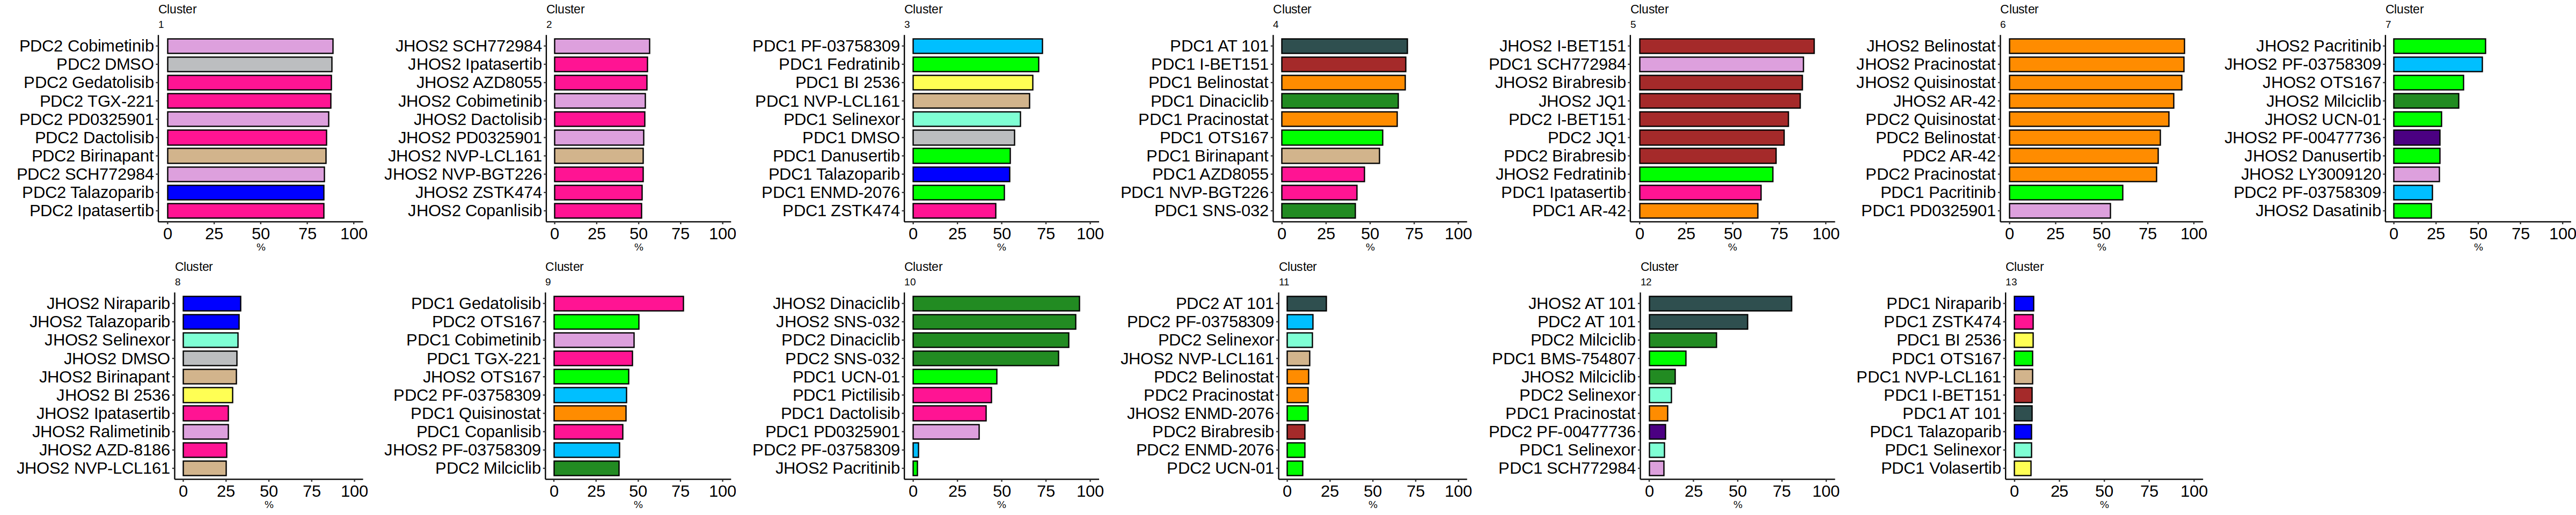

In [10]:
options(repr.plot.width = 40, repr.plot.height = 8)
plot_bars <- plot_grid(Integrated_cluster_1, 
                 Integrated_cluster_2, 
                 Integrated_cluster_3, 
                 Integrated_cluster_4, 
                 Integrated_cluster_5, 
                 Integrated_cluster_6,
                 Integrated_cluster_7, 
                 Integrated_cluster_8,
                 Integrated_cluster_9,
                 Integrated_cluster_10,
                 Integrated_cluster_11,
                 Integrated_cluster_12,
                 Integrated_cluster_13,
                 align = "h", nrow = 2)
plot_bars

The barcharts will be then adjusted in Adobe Illustrator for further details.

In [11]:
ggsave(plot_bars, filename = "IntegratedData_RNAclusters_barcharts_composition.pdf", width = 40, height = 8)

In [12]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Rocky Linux 8.8 (Green Obsidian)

Matrix products: default
BLAS/LAPACK: /homedir01/adini22/.conda/envs/cellhashing_analyses/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] readxl_1.4.1       ggsci_3.0.0        cowplot_1.1.1      viridis_0.6.2     
[5] viridisLite_0.4.1  ggplot2_3.4.2      SeuratObject_4.1.3 Seurat_4.3.0.9002 

loaded via a namespace (and not attached):
  [1] Rtsne_0.16             colorspace_2.1-0       deldir_1.0-6      